In [ ]:
%gui qt

In [41]:
import napari
import sys
Linux = True
if Linux:
    sys.path.insert(0,'/home/georgeos/Documents/GitHub/SYMPTOMM2')
else:
    sys.path.insert(0,'C:\\Users\\gh464\\Documents\\GitHub\\SYMPTOMM2\\')
from SYMPTOMM.cell import Cell
from SYMPTOMM.scene_functions import create_space, step_and_update
from SYMPTOMM.trench_geometry import trench_creator
from SYMPTOMM.phase_contrast_drawing import *
import tifffile
import numpy as np
from skimage.exposure import rescale_intensity
from skimage.transform import rescale, resize, downscale_local_mean
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from skimage.exposure import rescale_intensity
from ipywidgets import interactive
import os
from PIL import Image
import skimage
from tqdm.notebook import tqdm
import gc
from SYMPTOMM.PSF import get_phase_contrast_kernel, get_condensers
from skimage.segmentation import find_boundaries

#viewer = napari.view_image(real_image)


In [2]:
real_image_stack = tifffile.imread("/home/georgeos/Storage/Dropbox (Cambridge University)/Phase/real_data/Lane_02_pos_001_trench_x_0266_y_0059_w_0046_h_0460_c_Phase.tif")[:,:256,:]
real_image_stack.shape

(4368, 256, 46)

In [3]:
real_image_stack = resize(real_image_stack,(4368,128,23), order=1, mode='reflect', cval=0, clip=True, preserve_range=True, anti_aliasing=None, anti_aliasing_sigma=None)

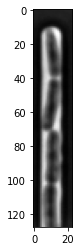

In [4]:
real_image = deepcopy(real_image_stack[123,:256,:])
plt.imshow(real_image,cmap="Greys_r")

### Scope props

In [5]:
condensers = get_condensers()
W, R, diameter = condensers["Ph3"]
radius=50
#F = 5
λ = 0.75
resize_amount = 3
pix_mic_conv = 0.0655*2 ##0.108379937 micron/pix for 60x, 0.0655 for 100x
scale = pix_mic_conv / resize_amount 
min_sigma = 0.42*0.6/6 / scale # micron#
sigma=min_sigma
NA=1.45
n = 1.4
kernel_params = (R,W,radius,scale,NA,n,sigma,λ)

#kernel_params = (R,W,radius,scale,F,sigma,λ)


### Do long cells

In [6]:
sim_length = 5
cell_timeseries, space = run_simulation(
    trench_length=15, 
    trench_width=1.5, 
    cell_max_length=5.5, 
    cell_width= 1,
    sim_length = sim_length,
    pix_mic_conv = pix_mic_conv,
    gravity=0,
    phys_iters=20,
    max_length_var = 3,
    width_var = 0.03
) # growth phase
main_segments = get_trench_segments(space)
ID_props = generate_curve_props(cell_timeseries)
cell_timeseries_properties = Parallel(n_jobs=-1)(
    delayed(gen_cell_props_for_draw)(a, ID_props) for a in tqdm(cell_timeseries, desc='Timeseries Properties'))
do_transformation = True
offset = 30
mask_threshold = 12
label_masks = False
space_size = get_space_size(cell_timeseries_properties)
scenes = Parallel(n_jobs=-1)(delayed(draw_scene)(
    cell_properties, do_transformation, mask_threshold, space_size, offset, label_masks) for cell_properties in tqdm(cell_timeseries_properties, desc='Scene Draw:'))

Simulation Progress: 100%|██████████| 255/255 [00:01<00:00, 180.10it/s]


Timeseries Properties:   0%|          | 0/4 [00:00<?, ?it/s]

Scene Draw::   0%|          | 0/4 [00:00<?, ?it/s]

In [111]:
def draw_scene(cell_properties, do_transformation, mask_threshold, space_size, offset, label_masks):
    space_size = np.array(space_size) # 1000, 200 a good value
    space = np.zeros(space_size)
    space_masks_label = np.zeros(space_size)
    space_masks_nolabel = np.zeros(space_size)    
    colour_label = [1]
    
    for properties in cell_properties:
        length, width, angle, position, freq_modif, amp_modif, phase_modif,phase_mult = properties
        length = length; width = width ; position = np.array(position) 
        angle = np.rad2deg(angle) - 90
        x = np.array(position).astype(int)[0] + offset
        y = np.array(position).astype(int)[1] + offset
        OPL_cell = raster_cell(length = length, width=width)

        if do_transformation:
            OPL_cell_2 = np.zeros((OPL_cell.shape[0],int(OPL_cell.shape[1]*2)))
            midpoint = int(np.median(range(OPL_cell_2.shape[1])))
            OPL_cell_2[:,midpoint-int(OPL_cell.shape[1]/2):midpoint-int(OPL_cell.shape[1]/2)+OPL_cell.shape[1]] = OPL_cell
            roll_coords = np.array(range(OPL_cell_2.shape[0]))
            freq_mult = (OPL_cell_2.shape[0])
            amp_mult = OPL_cell_2.shape[1]/10
            sin_transform_cell = transform_func(amp_modif, freq_modif, phase_modif)
            roll_amounts = sin_transform_cell(roll_coords,amp_mult,freq_mult,phase_mult)
            for B in roll_coords:
                OPL_cell_2[B,:] = np.roll(OPL_cell_2[B,:], roll_amounts[B])
            OPL_cell = (OPL_cell_2)

        rotated_OPL_cell = rotate(OPL_cell,angle,resize=True,clip=False,preserve_range=True)
        cell_y, cell_x = (np.array(rotated_OPL_cell.shape)/2).astype(int)
        offset_y = rotated_OPL_cell.shape[0] - space[y-cell_y:y+cell_y,x-cell_x:x+cell_x].shape[0]
        offset_x = rotated_OPL_cell.shape[1] - space[y-cell_y:y+cell_y,x-cell_x:x+cell_x].shape[1]
        assert y > cell_y, "Cell has {} negative pixels in y coordinate, try increasing your offset".format(y - cell_y)
        assert x > cell_x, "Cell has negative pixels in x coordinate, try increasing your offset"
        space[
            y-cell_y:y+cell_y+offset_y,
            x-cell_x:x+cell_x+offset_x
        ] += rotated_OPL_cell

        def get_mask(label_masks):
            
            if label_masks:
                space_masks_label[y-cell_y:y+cell_y+offset_y,x-cell_x:x+cell_x+offset_x] += (rotated_OPL_cell > 0)*colour_label[0]
                colour_label[0] += 1
                return space_masks_label
            else:
                space_masks_nolabel[y-cell_y:y+cell_y+offset_y,x-cell_x:x+cell_x+offset_x] += (rotated_OPL_cell > 0)*1
                return space_masks_nolabel
                #space_masks = opening(space_masks,np.ones((2,11)))
            
            
        label_mask = get_mask(True).astype(int)
        nolabel_mask = get_mask(False).astype(int)
        label_mask_fixed = np.where(nolabel_mask > 1,0,label_mask)
        mask_borders = find_boundaries(label_mask_fixed,mode="outer")
        space_masks = np.where(mask_borders, 0,label_mask_fixed)
        if label_masks == False:
            space_masks = space_masks.astype(bool)
    return space, space_masks

In [112]:
test = draw_scene(cell_timeseries_properties[-1],do_transformation, mask_threshold, space_size, offset, False)

In [114]:
plt.imshow(label(test[1]))

NameError: name 'label' is not defined

In [60]:
label_mask  = draw_scene(cell_timeseries_properties[-1],do_transformation, mask_threshold, space_size, offset, True)[1].astype(int)

In [61]:
nolabel_mask = draw_scene(cell_timeseries_properties[-1],do_transformation, 0, space_size, offset, False)[1].astype(int)

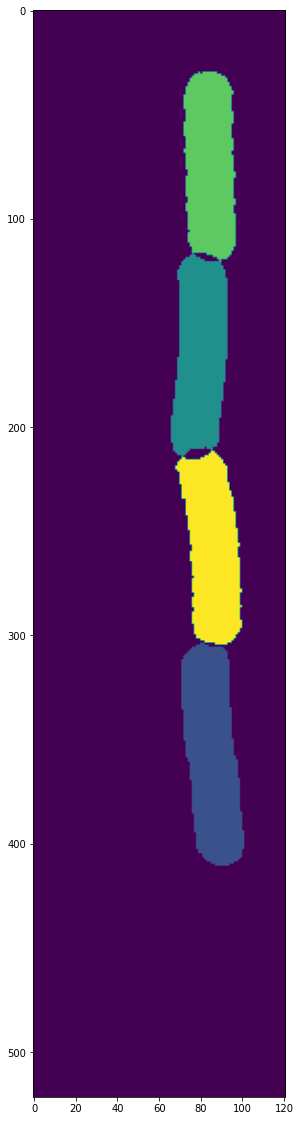

In [62]:
plt.figure(figsize=(20,20))
label_mask_fixed = np.where(nolabel_mask > 1,0,label_mask)
plt.imshow(label_mask_fixed)

In [63]:
mask_borders = find_boundaries(label_mask_fixed,mode="outer")

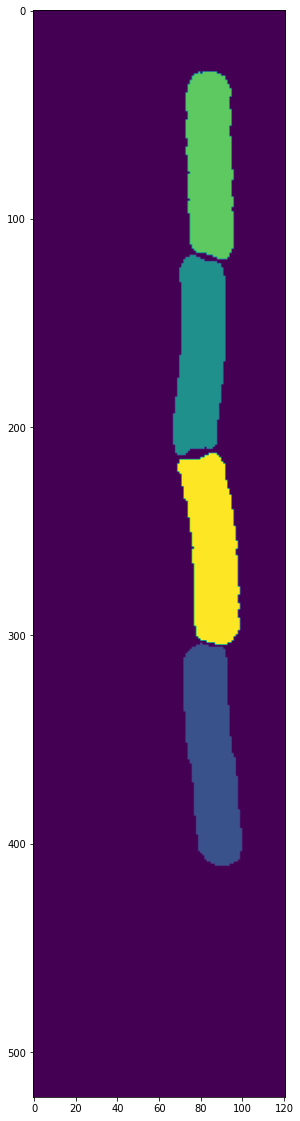

In [71]:
label_mask_no_touching = np.where(mask_borders, 0,label_mask_fixed)
plt.figure(figsize=(20,20))
plt.imshow(label_mask_no_touching)

In [93]:
@interact(x=(0,len(scenes)-1))
def f(x):
    plt.figure(figsize=(30,30))
    plt.imshow((scenes[x][0]))
    plt.show()

interactive(children=(IntSlider(value=249, description='x', max=498), Output()), _dom_classes=('widget-interac…

In [16]:
@interact(x=(0,len(scenes)-1))
def f(x):
    plt.figure(figsize=(30,30))
    plt.imshow(np.where(scenes[x][1] == 1,1,np.zeros(scenes[x][1].shape)))
    plt.show()

interactive(children=(IntSlider(value=249, description='x', max=498), Output()), _dom_classes=('widget-interac…

In [78]:
media_multiplier=30
cell_multiplier=1
device_multiplier=-50
y_border_expansion_coefficient = 3
x_border_expansion_coefficient = 3



temp_expanded_scene, temp_expanded_scene_no_cells, temp_expanded_mask = generate_PC_OPL(
   main_segments=main_segments,
    offset=offset,
    scene = scenes[0][0],
    mask = scenes[0][1],
    media_multiplier=media_multiplier,
    cell_multiplier=cell_multiplier,
    device_multiplier=cell_multiplier,
    y_border_expansion_coefficient = y_border_expansion_coefficient,
    x_border_expansion_coefficient = x_border_expansion_coefficient
)



### Generate temporary image to make same shape
temp_kernel = get_phase_contrast_kernel(*kernel_params)
convolved = convolve_rescale(temp_expanded_scene, temp_kernel, 1/resize_amount, rescale_int = True)
real_resize, expanded_resized = make_images_same_shape(real_image,convolved, rescale_int=True)

In [80]:
convolved.shape

(353, 74)

In [25]:
viewer = napari.view_image(real_resize)
media_label = viewer.add_labels(np.zeros(real_resize.shape).astype(int), name = "media")
cell_label = viewer.add_labels(np.zeros(real_resize.shape).astype(int), name = "cell")
device_label = viewer.add_labels(np.zeros(real_resize.shape).astype(int), name = "device")

In [83]:
real_media_mean = real_resize[np.where(media_label.data)].mean();
real_cell_mean = real_resize[np.where(cell_label.data)].mean(); 
real_device_mean = real_resize[np.where(device_label.data)].mean()
real_means = np.array((real_media_mean, real_cell_mean, real_device_mean))

real_media_var = real_resize[np.where(media_label.data)].var();
real_cell_var = real_resize[np.where(cell_label.data)].var(); 
real_device_var = real_resize[np.where(device_label.data)].var()
real_vars = np.array((real_media_var, real_cell_var, real_device_var))

image_params = (real_media_mean, real_cell_mean, real_device_mean, real_means, real_media_var, real_cell_var, real_device_var, real_vars)

In [113]:
mean_error = []
media_error = []
cell_error = []
device_error = []

mean_var_error = []
media_var_error = []
cell_var_error = []
device_var_error = []

error_params = (mean_error,media_error,cell_error,device_error,mean_var_error,media_var_error,cell_var_error,device_var_error)

params = interactive(
    generate_test_comparison,
    media_multiplier=(-300,300,1),
    cell_multiplier=(-30,30,0.01),
    device_multiplier=(-300,300,1),
    sigma=(min_sigma,min_sigma*20, min_sigma/20),
    scene_no = (0,sim_length-2,1),
    noise_var=(0,0.01, 0.0001),
    scale=fixed(scale),
    match_fourier = [True, False],
    match_histogram = [True, False],
    match_noise = [True, False],
    offset=fixed(offset),
    main_segments = fixed(main_segments),
    debug_plot=fixed(True),
    scenes = fixed(scenes),
    kernel_params = fixed(kernel_params),
    resize_amount = fixed(resize_amount), 
    real_image = fixed(real_image),
    image_params = fixed(image_params),
    error_params = fixed(error_params),
    x_border_expansion_coefficient = fixed(x_border_expansion_coefficient),
    y_border_expansion_coefficient = fixed(y_border_expansion_coefficient)
);

In [116]:
params

interactive(children=(IntSlider(value=0, description='media_multiplier', max=300, min=-300), FloatSlider(value…

In [111]:
generate_training_data(interactive_output = params, sample_amount = 0.025, randomise_hist_match = False, randomise_noise_match = False, sim_length = sim_length, burn_in = 0, n_samples =  1000, save_dir = "/home/georgeos/Storage/Dropbox (Cambridge University)/Phase/delta_hist_mid_large/")


Sample generation:   0%|          | 0/1000 [00:00<?, ?it/s]/home/georgeos/Documents/GitHub/SYMPTOMM2/SYMPTOMM/PSF.py:105: RuntimeWarning: invalid value encountered in true_divide
  kernel1 = 2*jv(1,rr)/(rr)
/home/georgeos/Documents/GitHub/SYMPTOMM2/SYMPTOMM/PSF.py:108: RuntimeWarning: invalid value encountered in true_divide
  kernel2 = 2*(R-W)**2/R**2 * jv(1,(R-W)**2/R**2 * rr)/rr


AssertionError: All images must have the same size.

### Do very large cells

In [56]:
sim_length = 300
cell_timeseries, space = run_simulation(
    trench_length=15, 
    trench_width=1.45, 
    cell_max_length=10.5,
    cell_width= 1.08, 
    sim_length = sim_length, 
    pix_mic_conv = pix_mic_conv,
    gravity=20,
    phys_iters=50,
    max_length_var = 3,
    width_var = 0.03
) # growth phase
main_segments = get_trench_segments(space)
ID_props = generate_curve_props(cell_timeseries)
cell_timeseries_properties = Parallel(n_jobs=-1)(
    delayed(gen_cell_props_for_draw)(a, ID_props) for a in tqdm(cell_timeseries, desc='Timeseries Properties'))
do_transformation = True
offset = 30
mask_threshold = 18
label_masks = True
space_size = get_space_size(cell_timeseries_properties)
scenes = Parallel(n_jobs=-1)(delayed(draw_scene)(
    cell_properties, do_transformation, mask_threshold, space_size, offset, label_masks) for cell_properties in tqdm(cell_timeseries_properties, desc='Scene Draw'))

Simulation Progress: 100%|██████████| 550/550 [00:09<00:00, 60.04it/s] 


Timeseries Properties:   0%|          | 0/299 [00:00<?, ?it/s]

Scene Draw:   0%|          | 0/299 [00:00<?, ?it/s]

In [57]:
media_multiplier=30
cell_multiplier=1
device_multiplier=-50
y_border_expansion_coefficient = 3
x_border_expansion_coefficient = 3



temp_expanded_scene, temp_expanded_scene_no_cells, temp_expanded_mask = generate_PC_OPL(
   main_segments=main_segments,
    offset=offset,
    scene = scenes[0][0],
    mask = scenes[0][1],
    media_multiplier=media_multiplier,
    cell_multiplier=cell_multiplier,
    device_multiplier=cell_multiplier,
    y_border_expansion_coefficient = y_border_expansion_coefficient,
    x_border_expansion_coefficient = x_border_expansion_coefficient
)



### Generate temporary image to make same shape
temp_kernel = get_phase_contrast_kernel(*kernel_params)
convolved = convolve_rescale(temp_expanded_scene, temp_kernel, 1/resize_amount, rescale_int = True)
real_resize, expanded_resized = make_images_same_shape(real_image,convolved, rescale_int=True)



In [58]:
real_media_mean = real_resize[np.where(media_label.data)].mean();
real_cell_mean = real_resize[np.where(cell_label.data)].mean(); 
real_device_mean = real_resize[np.where(device_label.data)].mean()
real_means = np.array((real_media_mean, real_cell_mean, real_device_mean))

real_media_var = real_resize[np.where(media_label.data)].var();
real_cell_var = real_resize[np.where(cell_label.data)].var(); 
real_device_var = real_resize[np.where(device_label.data)].var()
real_vars = np.array((real_media_var, real_cell_var, real_device_var))

image_params = (real_media_mean, real_cell_mean, real_device_mean, real_means, real_media_var, real_cell_var, real_device_var, real_vars)

In [62]:
mean_error = []
media_error = []
cell_error = []
device_error = []

mean_var_error = []
media_var_error = []
cell_var_error = []
device_var_error = []

error_params = (mean_error,media_error,cell_error,device_error,mean_var_error,media_var_error,cell_var_error,device_var_error)

params = interactive(
    generate_test_comparison,
    media_multiplier=(-300,300,1),
    cell_multiplier=(-30,30,0.01),
    device_multiplier=(-300,300,1),
    sigma=(min_sigma,min_sigma*20, min_sigma/20),
    scene_no = (0,sim_length-2,1),
    noise_var=(0,0.01, 0.0001),
    scale=(scale,scale,scale),
    match_fourier = [True, False],
    match_histogram = [True, False],
    match_noise = [True, False],
    offset=fixed(offset),
    main_segments = fixed(main_segments),
    debug_plot=fixed(True),
    scenes = fixed(scenes),
    kernel_params = fixed(kernel_params),
    resize_amount = fixed(resize_amount), 
    real_image = fixed(real_image),
    image_params = fixed(image_params),
    error_params = fixed(error_params),
    x_border_expansion_coefficient = fixed(x_border_expansion_coefficient),
    y_border_expansion_coefficient = fixed(y_border_expansion_coefficient)
);

In [63]:
params

interactive(children=(IntSlider(value=0, description='media_multiplier', max=300, min=-300), FloatSlider(value…

In [64]:
generate_training_data(interactive_output = params, sample_amount = 0.05, randomise_hist_match = False, randomise_noise_match = False, sim_length = sim_length, burn_in = 0, n_samples =  900, save_dir = "/home/georgeos/Storage/Dropbox (Cambridge University)/Phase/fourier_hist_mid_large/")

Sample generation:   0%|          | 0/900 [00:00<?, ?it/s]

### Do medium cells

In [118]:
sim_length = 300
cell_timeseries, space = run_simulation(
    trench_length=15, 
    trench_width=1.5, 
    cell_max_length=6.7, 
    cell_width=1.09, 
    sim_length = sim_length, 
    pix_mic_conv = pix_mic_conv,
    gravity=-4,
    phys_iters=35,
    max_length_var = 1,
    width_var = 0.06
) # growth phase
main_segments = get_trench_segments(space)
ID_props = generate_curve_props(cell_timeseries)
cell_timeseries_properties = Parallel(n_jobs=-1)(
    delayed(gen_cell_props_for_draw)(a, ID_props) for a in tqdm(cell_timeseries, desc='Timeseries Properties'))
do_transformation = False
offset = 30
mask_threshold = 18
label_masks = True
space_size = get_space_size(cell_timeseries_properties)
scenes = Parallel(n_jobs=-1)(delayed(draw_scene)(
    cell_properties, do_transformation, mask_threshold, space_size, offset, label_masks) for cell_properties in tqdm(cell_timeseries_properties, desc='Scene Draw:'))

Simulation Progress: 100%|██████████| 550/550 [00:07<00:00, 78.40it/s] 


Timeseries Properties:   0%|          | 0/299 [00:00<?, ?it/s]

Scene Draw::   0%|          | 0/299 [00:00<?, ?it/s]

In [68]:
mean_error = []
media_error = []
cell_error = []
device_error = []

mean_var_error = []
media_var_error = []
cell_var_error = []
device_var_error = []

error_params = (mean_error,media_error,cell_error,device_error,mean_var_error,media_var_error,cell_var_error,device_var_error)

params = interactive(
    generate_test_comparison,
    media_multiplier=(-300,300,1),
    cell_multiplier=(-30,30,0.01),
    device_multiplier=(-300,300,1),
    sigma=(min_sigma,min_sigma*20, min_sigma/20),
    scene_no = (0,sim_length-2,1),
    noise_var=(0,0.01, 0.0001),
    scale=(scale,scale,scale),
    match_fourier = [True, False],
    match_histogram = [True, False],
    match_noise = [True, False],
    offset=fixed(offset),
    main_segments = fixed(main_segments),
    debug_plot=fixed(True),
    scenes = fixed(scenes),
    kernel_params = fixed(kernel_params),
    resize_amount = fixed(resize_amount), 
    real_image = fixed(real_image),
    image_params = fixed(image_params),
    error_params = fixed(error_params),
    x_border_expansion_coefficient = fixed(x_border_expansion_coefficient),
    y_border_expansion_coefficient = fixed(y_border_expansion_coefficient)
);

In [69]:
params

interactive(children=(IntSlider(value=0, description='media_multiplier', max=300, min=-300), FloatSlider(value…

In [71]:
generate_training_data(interactive_output = params, sample_amount = 0.05, randomise_hist_match = False, randomise_noise_match = False, sim_length = sim_length, burn_in = 0, n_samples =  900, save_dir = "/home/georgeos/Storage/Dropbox (Cambridge University)/Phase/fourier_hist_mid_large/")

Sample generation:   0%|          | 0/900 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Do small cells

In [77]:
sim_length = 1000
cell_timeseries, space = run_simulation(
    trench_length=15, 
    trench_width=1.5, 
    cell_max_length=8, 
    cell_width=1.09, 
    sim_length = sim_length, 
    pix_mic_conv = pix_mic_conv,
    gravity=-4,
    phys_iters=20,
    max_length_var = 1,
    width_var = 0.06
) # growth phase
main_segments = get_trench_segments(space)
ID_props = generate_curve_props(cell_timeseries)
cell_timeseries_properties = Parallel(n_jobs=-1)(
    delayed(gen_cell_props_for_draw)(a, ID_props) for a in tqdm(cell_timeseries, desc='Timeseries Properties'))
do_transformation = False
offset = 30
mask_threshold = 18
label_masks = True
space_size = get_space_size(cell_timeseries_properties)
scenes = Parallel(n_jobs=-1)(delayed(draw_scene)(
    cell_properties, do_transformation, mask_threshold, space_size, offset, label_masks) for cell_properties in tqdm(cell_timeseries_properties, desc='Scene Draw:'))

Simulation Progress: 100%|██████████| 1250/1250 [00:30<00:00, 40.79it/s]


Timeseries Properties:   0%|          | 0/999 [00:00<?, ?it/s]

Scene Draw::   0%|          | 0/999 [00:00<?, ?it/s]

In [78]:
mean_error = []
media_error = []
cell_error = []
device_error = []

mean_var_error = []
media_var_error = []
cell_var_error = []
device_var_error = []

error_params = (mean_error,media_error,cell_error,device_error,mean_var_error,media_var_error,cell_var_error,device_var_error)

params = interactive(
    generate_test_comparison,
    media_multiplier=(-300,300,1),
    cell_multiplier=(-30,30,0.01),
    device_multiplier=(-300,300,1),
    sigma=(min_sigma,min_sigma*20, min_sigma/20),
    scene_no = (0,sim_length-2,1),
    noise_var=(0,0.01, 0.0001),
    scale=(scale,scale,scale),
    match_fourier = [True, False],
    match_histogram = [True, False],
    match_noise = [True, False],
    offset=fixed(offset),
    main_segments = fixed(main_segments),
    debug_plot=fixed(True),
    scenes = fixed(scenes),
    kernel_params = fixed(kernel_params),
    resize_amount = fixed(resize_amount), 
    real_image = fixed(real_image),
    image_params = fixed(image_params),
    error_params = fixed(error_params),
    x_border_expansion_coefficient = fixed(x_border_expansion_coefficient),
    y_border_expansion_coefficient = fixed(y_border_expansion_coefficient)
);

In [79]:
params

interactive(children=(IntSlider(value=0, description='media_multiplier', max=300, min=-300), FloatSlider(value…

In [ ]:
generate_training_data(interactive_output = params, sample_amount = 0.05, randomise_hist_match = False, randomise_noise_match = False, sim_length = sim_length, burn_in = 0, n_samples =  5000, save_dir = "/home/georgeos/Storage/Dropbox (Cambridge University)/Phase/fourier_hist_mid_large/")

Sample generation:   0%|          | 0/5000 [00:00<?, ?it/s]

### Do a few very small cells

In [ ]:
sim_length = 100
cell_timeseries, space = run_simulation(
    trench_length=15, 
    trench_width=1.5, 
    cell_max_length=1.9, 
    cell_width=1.05, 
    sim_length = sim_length, 
    pix_mic_conv = pix_mic_conv,
    gravity=-7,
    phys_iters=25,
    max_length_var = 2,
    width_var = 0.06
) 
main_segments = get_trench_segments(space)
ID_props = generate_curve_props(cell_timeseries)
cell_timeseries_properties = Parallel(n_jobs=-1)(
    delayed(gen_cell_props_for_draw)(a, ID_props) for a in tqdm(cell_timeseries, desc='Timeseries Properties'))
do_transformation = False
offset = 40
mask_threshold = 18
label_masks = True
space_size = get_space_size(cell_timeseries_properties)
scenes = Parallel(n_jobs=-1)(delayed(draw_scene)(
    cell_properties, do_transformation, mask_threshold, space_size, offset, label_masks) for cell_properties in tqdm(cell_timeseries_properties, desc='Scene Draw:'))

In [ ]:
mean_error = []
media_error = []
cell_error = []
device_error = []

mean_var_error = []
media_var_error = []
cell_var_error = []
device_var_error = []

error_params = (mean_error,media_error,cell_error,device_error,mean_var_error,media_var_error,cell_var_error,device_var_error)

params = interactive(
    generate_test_comparison,
    media_multiplier=(-300,300,1),
    cell_multiplier=(-30,30,0.01),
    device_multiplier=(-300,300,1),
    sigma=(min_sigma,min_sigma*20, min_sigma/20),
    scene_no = (0,sim_length-2,1),
    noise_var=(0,0.01, 0.0001),
    scale=(scale,scale,scale),
    match_histogram = [True, False],
    match_noise = [True, False],
    offset=fixed(offset),
    main_segments = fixed(main_segments),
    debug_plot=fixed(True),
    scenes = fixed(scenes),
    kernel_params = fixed(kernel_params),
    resize_amount = fixed(resize_amount), 
    real_image = fixed(real_image),
    image_params = fixed(image_params),
    error_params = fixed(error_params),
    x_border_expansion_coefficient = fixed(x_border_expansion_coefficient),
    y_border_expansion_coefficient = fixed(y_border_expansion_coefficient)
);

In [ ]:
params

In [ ]:
generate_training_data(interactive_output = params, sample_amount = 0.05, randomise_hist_match = False, randomise_noise_match = False, sim_length = sim_length, burn_in = 0, n_samples =  500, save_dir = "/home/georgeos/Storage/Dropbox (Cambridge University)/Phase/training_data_exponential_nohist_homogeneous/")

### Do a few empty trenches with different sizes

Rememebr to set `cell_multiplier` to 0

In [ ]:
params

In [ ]:
generate_training_data(interactive_output = params, sample_amount = 0.1, randomise_hist_match = False, randomise_noise_match = False, sim_length = sim_length, burn_in = 0, n_samples =  15, save_dir = "/home/georgeos/Storage/Dropbox (Cambridge University)/Phase/training_data/")